# 딥러닝 활용한 타이타닉 생존자 예측

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<br>

### 1. Data loading & preprocessing

In [6]:
titanic_df = pd.read_csv("data/titanic.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
# preprocessiong
del titanic_df['Cabin'] 
del titanic_df['PassengerId']
del titanic_df['Ticket']

# name
titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
del titanic_df['Name'] # 호칭만 남김

rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)

# sex
sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)

# embarked
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)

# fare
titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0,
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1,
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2,
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4

# party
titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
del titanic_df['SibSp']
del titanic_df['Parch']

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)


titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0,
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1,
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2,
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3,
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


<br>

### 2. Train / Test Split

In [8]:
titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [9]:
from sklearn import model_selection

train_data, test_data, train_label, test_label = model_selection.train_test_split(titanic_data,
                                                                                  titanic_target,
                                                                                  test_size=0.3,
                                                                                  random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(623, 8)
(268, 8)
(623, 1)
(268, 1)


<br>

### 3. Change normal labels to one-hot labels

In [10]:
train_label[:5]

,Survived
857,1
52,1
386,0
124,0
578,0


In [ ]:
# from tensorflow.keras import utils
# train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
# test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

In [11]:
from sklearn import preprocessing

# Apply 'One-hot encoding' on labels
enc = preprocessing.OneHotEncoder(categories='auto')

train_label = enc.fit_transform(train_label).toarray()
test_label = enc.fit_transform(test_label).toarray()

print(train_label.shape)
print(test_label.shape)

(623, 2)
(268, 2)


In [13]:
train_label[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

<br>

## 4. Build & Train the model 

In [15]:
import tensorflow as tf

from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

import os
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [16]:
train_data.shape

(623, 8)

In [17]:
model = models.Sequential()

model.add(layers.Dense(input_dim=8, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization

# model.add(layers.BatchNormalization()) # Use this line as if needed

model.add(layers.Activation('elu')) # elu, relu / layers.ELU, layers.LeakyReLU

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

# 마지막 hidden layer droup out
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output

In [18]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [19]:
history = model.fit(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3) 

Train on 436 samples, validate on 187 samples
Epoch 1/20
436/436 [==============================] - 1s 2ms/sample - loss: 2.5303 - categorical_accuracy: 0.6101 - val_loss: 3.8353 - val_categorical_accuracy: 0.5615
Epoch 2/20
436/436 [==============================] - 0s 197us/sample - loss: 1.9562 - categorical_accuracy: 0.6628 - val_loss: 1.0735 - val_categorical_accuracy: 0.6310
Epoch 3/20
436/436 [==============================] - 0s 193us/sample - loss: 1.0664 - categorical_accuracy: 0.7110 - val_loss: 1.3267 - val_categorical_accuracy: 0.6471
Epoch 4/20
436/436 [==============================] - 0s 188us/sample - loss: 0.8191 - categorical_accuracy: 0.7592 - val_loss: 0.4816 - val_categorical_accuracy: 0.7968
Epoch 5/20
436/436 [==============================] - 0s 197us/sample - loss: 0.7225 - categorical_accuracy: 0.7431 - val_loss: 0.6481 - val_categorical_accuracy: 0.7166
Epoch 6/20
436/436 [==============================] - 0s 229us/sample - loss: 0.6740 - categorical_accurac

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
__________

In [21]:
result = model.evaluate(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

268/268 [==============================] - 0s 101us/sample - loss: 0.5247 - categorical_accuracy: 0.8209
loss (cross-entropy) : 0.5246544667144319
test accuracy : 0.8208955


In [22]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

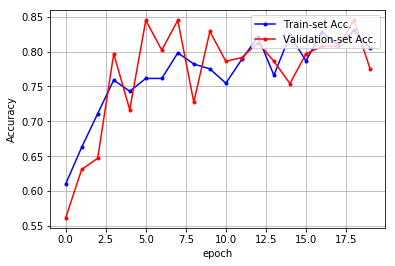

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

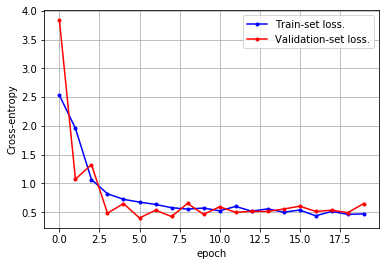

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

<br>

### Sample Data predict

In [26]:
sample_data = np.array([[3, 0, 0.0, 0.0, 1, 1, 2.0, 0]])

In [27]:
model.predict(sample_data)

array([[0.9919294 , 0.00807057]], dtype=float32)

In [28]:
np.argmax(model.predict(sample_data), axis=1)

array([0], dtype=int64)

-> unsurvived